<a href="https://colab.research.google.com/github/LukszaLab/CFITworkshop/blob/main/Immunoediting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Immunoediting in cancer evolution**

Download and install CFIT repository

In [ ]:
%cd ../
%rm -fr CFITworkshop

In [ ]:
!git clone https://github.com/LukszaLab/CFITworkshop.git

%cd CFITworkshop
!pip install -e .

In [ ]:
import json
import glob
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from scipy.stats import pearsonr, linregress
from collections import defaultdict

from cfit.fitness.HLAweights import HLAweights
from cfit.fitness.ImmuneCloneFitness import ImmuneCloneFitness
from cfit.fitness.VariableImmuneCloneFitness import VariableImmuneCloneFitness
from cfit.fitness.DGCloneFitness import DGCloneFitness
from cfit.fitness.neo_quality.CARNeoantigenQuality import CARNeoantigenQuality
from cfit.fitness.neo_quality.ARNeoantigenQuality import ARNeoantigenQuality
from cfit.plot.PlotTreeAll import PlotTreeAll
from cfit.tree.mutation.Neoantigen import Neoantigen
from cfit.util.Analysis import Analysis
from cfit.util.Analysis import AnalysisArgs
from cfit.util.Log import Log
from cfit.util.Utils import Utils

In [ ]:
def plot_response(df, max_tau, sample):
    # Define time points
    tau = np.linspace(0, max_tau+max_tau*0.5, 200)

    # Compute X_alpha(tau) for each clone
    X = []
    for idx, row in df.iterrows():
        X_alpha_tau = row['X0'] * np.exp(row['F'] * tau)
        X.append(X_alpha_tau)

    X = np.array(X)

    # Create figure with two subplots: dynamics and fitness
    fig, (ax_main, ax_bar) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]})

    # Main stacked area plot
    stack = ax_main.stackplot(tau, X, labels=df['Clone'], alpha=0.85)
    ax_main.set_xlabel(r'$\tau$ (therapy time)')
    ax_main.set_ylabel(r'$X_\alpha(\tau)$')
    a#x_main.plot([max_tau, max_tau],[0,1],color='black')

    ax_main.axvline(x=max_tau, color='black', linestyle='--', linewidth=1.5)

    # Add annotation
    ax_main.annotate(
        r'$\tau$',                    # LaTeX-style tau
        xy=(max_tau, 1),            # location of the arrow
        xytext=(max_tau*1.01, .95),# location of the text
        #arrowprops=dict(arrowstyle='->', color='black'),
        fontsize=12,
        color='black'
    )

    ax_main.set_title('Predicted dynamics of cancer cell clones for sample '+sample)
    ax_main.legend(loc='upper right')

    # Fitness bar plot
    bars = ax_bar.bar(df['Clone'], df['F'], color=[s.get_facecolor() for s in stack])
    ax_bar.axhline(0, color='black', linewidth=0.8)
    ax_bar.set_title('Fitness values')
    ax_bar.set_ylabel(r'$F_\alpha$')
    ax_bar.set_xticks(range(len(df['Clone'])))
    ax_bar.set_xticklabels(df['Clone'])

    plt.tight_layout()
    plt.show()

def compare_cohorts(data, col='ntau', ylabel=None):
    ax = sns.swarmplot(x='Cohort', y=col, data=data, dodge=True)
    sns.boxplot(x='Cohort', y=col, data=data,
                      boxprops={'facecolor': 'None'})
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], frameon=False)
    x1 = data[data.Cohort == 'STS'][col]
    x2 = data[data.Cohort != 'STS'][col]
    try:
        pval = scipy.stats.mannwhitneyu(x1, x2, alternative='two-sided').pvalue
    except:
        pval = 0.0
    ax.set_title("pvalue=" + str(pval))
    if ylabel is None:
        ylabel = col
    ax.set_ylabel(ylabel)
    plt.show()


# Parameters

Text(0.5, 1.0, 'R function - alignement with IEDB epitopes')

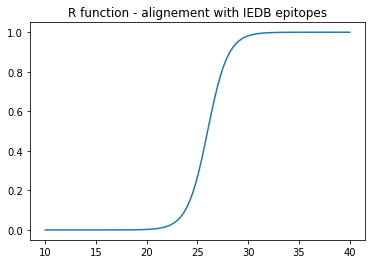

In [ ]:
#Neoantigen model paramaters
tau = 0.04
a = 26.
k = 1.
aln_scores = np.linspace(10,40,100)
plt.plot(aln_scores, np.exp(k*(aln_scores-a))/(1+np.exp(k*(aln_scores-a))))
plt.title("R function - alignement with IEDB epitopes")
plt.show()


# Initialize all data:
- patient metadata
- mutations
- neoantigens
- trees with clones annotated with mutations, neoantigens
- clone tumor frequenies


In [ ]:
#%cd CFITworkshop
hdir='test/Data_PDAC_2017'
args = AnalysisArgs()
args.netMHC = "3.4"
args.kd_thr = 500 # threshold on neoantigen Kd
args.dir = hdir

anl = Analysis()
anl.set_MHC_version(args.netMHC)
mappingfile = os.path.join(args.dir, "mapping.json")
with open(mappingfile) as f:
    mappingjs = json.load(f)
configfile = os.path.join(args.dir, "config.json")
with open(configfile) as f:
    configjs = json.load(f)
vcfdir = os.path.join(args.dir, configjs["vcf_dir"])
alndir = os.path.join(args.dir, configjs["aln_dir"])
iedbfasta = os.path.join(alndir, "enemy.fasta")

anl.initialize_config(configjs, mappingjs, args=args)

Distribution of overall survival of patients in the PDAC cohort

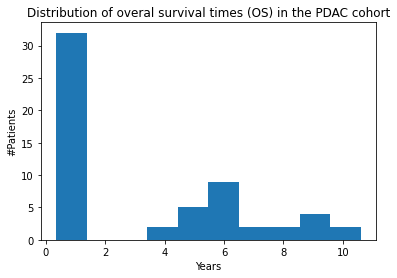

In [ ]:
patients = list(anl.patients.values())
plt.hist([pat.OS for pat in patients])
plt.title("Distribution of overal survival times (OS) in the PDAC cohort")
plt.xlabel("Years")
plt.ylabel("#Patients")
plt.show()

sts_patients = [patient for patient in patients if patient.OS<=2]
lts_patients = [patient for patient in patients if patient.OS>2]


Compute neoantigen qualities:

In [ ]:
# 1. compute neoantigen qualities

Qmodel = ARNeoantigenQuality(alndir=alndir, iedbfasta=iedbfasta)
anl.set_neantigen_quality_model(Qmodel)
anl.compute_neoantigen_sample_qualities(a=a, k=k, HLAW=HLAweights('1-9'), include_A=True, include_R=True, kdthr=args.kd_thr, KDnormalize=1.)


Define the fitness model:

In [ ]:
# 2. set fitness model components

#aggrfun is an argument that describes the function we use to aggregate over neoantigens in a clone
#max function picks the neoantigen of the highest "quality", consistent if immunodominance model

qualityFitnessModelComp = ImmuneCloneFitness(aggrfun=max)
anl.set_fitness_model_component(qualityFitnessModelComp, "immune", 1.)
anl.compute_node_fitness(recompute_components=True)

Lets look at predicted clone dynamics of individual patients

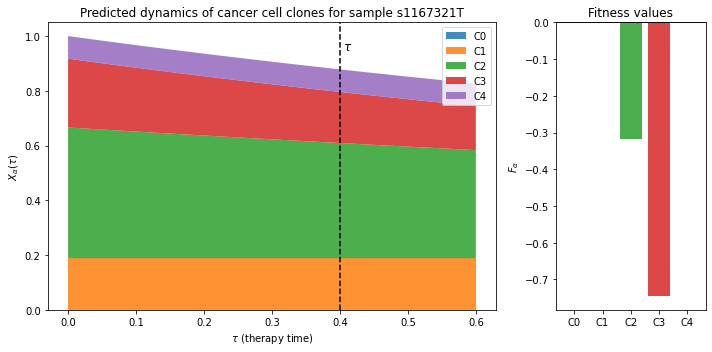

In [ ]:
sts_patient = sts_patients[4]
plottree = PlotTreeAll(sts_patient, drivers=["TP53","KRAS","CDKN2A", "SMAD4"], tid=0, save_html=False, show=True)
df=pd.DataFrame([["C"+str(node.id), node.Y,node.fitness] for node in anl.samples[sts_patient.name].trees[0].nodes.values()],columns=["Clone","X0","F"])
plot_response(df, 0.4, sts_patient.name)

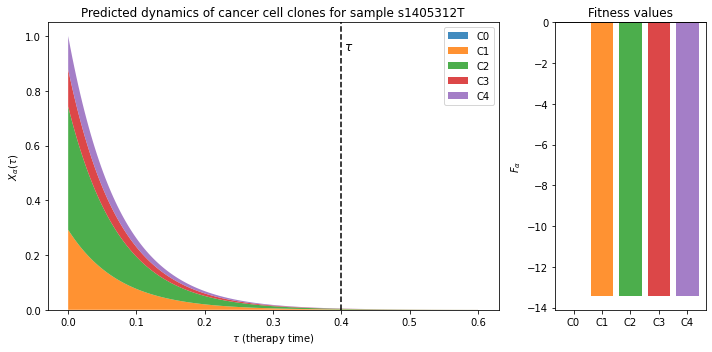

In [ ]:
lts_patient = lts_patients[13] # 13, 18 - strong clonal neoantigen, 19 - 2 subclonal neoantigens, 20 - dominant subclone with driver genes also has a neoantigen
plottree = PlotTreeAll(lts_patient, drivers=["TP53","KRAS","CDKN2A", "SMAD4"], tid=0, save_html=False, show=True)
df=pd.DataFrame([["C"+str(node.id), node.Y,node.fitness] for node in anl.samples[lts_patient.name].trees[0].nodes.values()],columns=["Clone","X0","F"])
plot_response(df, 0.4, lts_patient.name)

# Survival analysis

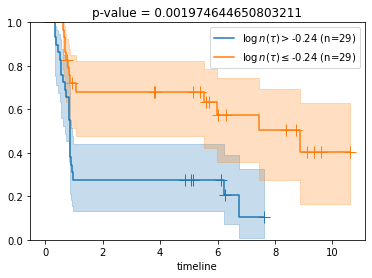

In [ ]:
# Survival analysis
res_surv = anl.classify_survival(beta=1., tau=tau, outdir=None, OS=True, PFS=True, quantile=0.5)
anl.plot_survival(OS=True, pval=res_surv["pval_OS"], quantile=0.5, show=True)


Other statistics of the patient samples:

In [ ]:
patnames = list(anl.patients.keys())
sample_statistics = anl.sample_statistics(kd_thr=args.kd_thr)
fitness_statistics = anl.fitness_sample_statistics()
data = pd.DataFrame(zip(patnames, [anl.patients[patname].OS for patname in patnames],[np.exp(anl.patients[patname].q) for patname in patnames]), columns=["Sample","OS","ntau"])
data["Cohort"] = ["STS" if os<=2 else "LTS" for os in data.OS]
data = pd.merge(data, sample_statistics, on='Sample')

data

,Sample,OS,ntau,Cohort,TMB,TMB_nsyn,TMB_syn,TMB_MHC,TNB,TMB_eff,TMB_nsyn_eff,TMB_syn_eff,TMB_MHC_eff,TNB_eff,nclones,neff_clones,entropy
0,s1185621T,9.60,0.224468,LTS,6647.0,2316,1031,998.0,1350,3836.254208,1249.955788,560.475991,535.578036,722.572141,3.000000,2.546106,0.934565
1,s1410022T,0.87,1.000000,STS,220.0,53,15,18.0,28,111.197867,17.175583,6.518900,6.592225,10.017161,3.999389,2.958327,1.084606
2,s1134131T,10.60,0.527505,LTS,203.0,60,22,31.0,61,74.793391,20.493201,6.997179,10.779840,21.650805,4.983483,4.172216,1.389673
3,s1200702T,9.36,0.779162,LTS,269.0,53,23,24.0,37,73.715197,10.719288,5.682857,4.374517,5.817271,5.990476,5.123252,1.633504
4,s1320801T,0.70,0.812825,STS,311.0,54,26,27.0,40,173.594636,28.296154,15.636123,11.799106,16.027267,3.730947,3.000163,1.094067
5,s1347022T,0.35,0.794894,STS,293.0,35,21,13.0,17,151.062040,10.515621,6.211768,3.681847,4.757810,3.000000,2.517737,0.923360
6,s1215112T,9.10,0.406538,LTS,1069.0,93,46,36.0,54,679.166224,28.249951,16.202936,10.185884,15.954316,4.000000,3.166838,1.152728
7,s1247561T,6.02,0.016823,LTS,1615.0,138,72,57.0,88,856.243751,41.245334,18.704476,18.886314,28.846794,5.000000,4.405593,1.482875
8,s1365871T,0.62,0.642660,STS,230.0,33,25,14.0,29,100.098445,12.065530,9.812536,4.446134,8.797636,4.000000,3.449083,1.238108
9,s1167321T,0.35,0.985932,STS,448.0,40,34,17.0,27,167.467933,12.354180,8.554800,4.950195,8.411788,3.746561,3.151698,1.138567


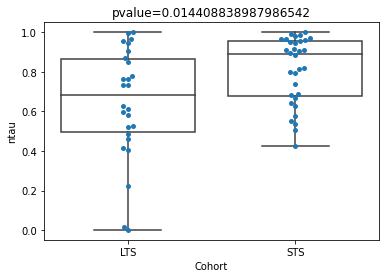

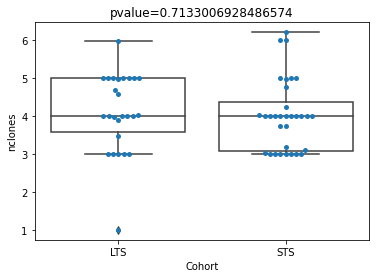

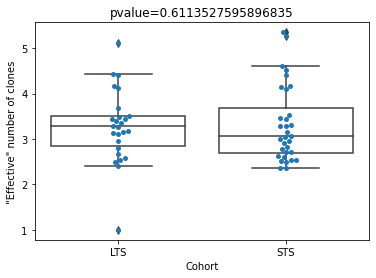

In [ ]:
compare_cohorts(data, 'ntau')
compare_cohorts(data, 'nclones')
compare_cohorts(data, 'neff_clones', ylabel='"Effective" number of clones')

## Alternative model - "quantity" of neantigens

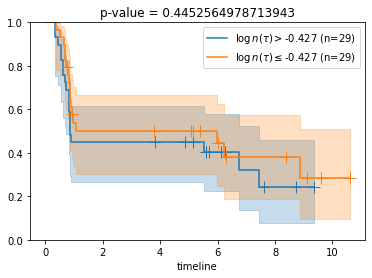

In [ ]:
quantityFitnessModelComp = VariableImmuneCloneFitness(quality_function=lambda neo, sampleTree, sample: 1, aggrfun=sum)
anl.set_fitness_model_component(quantityFitnessModelComp, "immune", 1.)
anl.compute_node_fitness(recompute_components=True)
# Survival analysis
res_surv = anl.classify_survival(beta=1., tau=tau, outdir=None, OS=True, PFS=True, quantile=0.5)
anl.plot_survival(OS=True, pval=res_surv["pval_OS"], quantile=0.5, show=True)


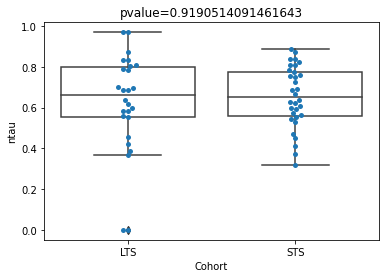

In [ ]:
patnames = list(anl.patients.keys())
sample_statistics = anl.sample_statistics(kd_thr=args.kd_thr)
fitness_statistics = anl.fitness_sample_statistics()
data = pd.DataFrame(zip(patnames, [anl.patients[patname].OS for patname in patnames],[np.exp(anl.patients[patname].q) for patname in patnames]), columns=["Sample","OS","ntau"])
data["Cohort"] = ["STS" if os<=2 else "LTS" for os in data.OS]
data = pd.merge(data, sample_statistics, on='Sample')
compare_cohorts(data, 'ntau')


# **Predicting clonal dynamics**

Functions implementing parameter fitting for clonal frequency dynamics between primary and metastatic tumors

In [ ]:
"""script for comparing fitness models and computing log-likelihood scores
"""

import glob
import json
import os
import numpy as np
import pandas as pd


def set_fitness_on_a_tree(tree, weights):
    '''
    Computes fitness of all clones in a tree as a weighted sum of fitness components,
    F_I and F_P

    :param tree: dict
        json representation of a tree

    :param weights: dict
        {"Sigma_I" -> float, "Sigma_P"->float}
    '''
    nodes = [tree["topology"]]
    while nodes:
        node = nodes[0]
        nodes = nodes[1:]
        if "predicted_x" in node:
            del node["predicted_x"]
        if "predicted_X" in node:
            del node["predicted_X"]
        if "children" in node:
            for child in node["children"]:
                nodes.append(child)
        node["fitness"] = node["F_I"] * weights["Sigma_I"] + node["F_P"] * weights["Sigma_P"]

def get_property(tree, property):
    '''
    Auxiliary function to extract a clone attribute values into a list
    :param tree: dict
        json representation of a tree

    :param property: str
        name of the attribute

    :return list
    '''
    nodes = [tree["topology"]]
    vals = []
    while nodes:
        node = nodes[0]
        nodes = nodes[1:]
        if "children" in node:
            for child in node["children"]:
                nodes.append(child)
        vals.append((node["clone_id"], node[property]))
    vals.sort(key=lambda x: x[0])
    vals = [x for (_, x) in vals]
    return vals


def KL_null_tree(prim_tree, rec_tree):
    '''
    Computes Kullback-Leibler divergence between the recurrent and the primary tumor tree.
    The topology of the clonal structure tree is common between the two time points,
    the probability distributions are defined by clone frequencies that differ between
    the two time points.

    :param prim_tree: dict
        json representation of a tree (primary tumor)

    :param rec_tree: dict
        json representation of a tree (recurrent tumor)

    :return float:
        Kullback-Leibler divergence value
    '''
    x0 = get_property(prim_tree, "tilde_x")
    observed_x = get_property(rec_tree, "tilde_x")
    pairs = list(zip(x0, observed_x))
    pairs = [x for x in pairs if x[1] > 0 and x[0] > 0]

    kl = sum(obs_x * np.log(obs_x / null_x) for (null_x, obs_x) in pairs)
    return kl


def KL_prediction_tree(prim_tree, rec_tree):
    '''
    Computes Kullback-Leibler divergence between the recurrent tumor tree and
    the tree predicted with the fitness model applied on the primary tree.
    The topology of the clonal structure tree is common between the two time points,
    the probability distributions are defined by the observed and predicted clone frequencies.

    :param prim_tree: dict
        json representation of a tree (primary tumor)

    :param rec_tree: dict
        json representation of a tree (recurrent tumor)

    :return float:
        Kullback-Leibler divergence value
    '''
    x0 = get_property(prim_tree, "tilde_x")
    observed_x = get_property(rec_tree, "tilde_x")
    predicted_x = get_property(prim_tree, "predicted_x")
    pairs = list(zip(predicted_x, observed_x, x0))
    pairs = [x for x in pairs if x[2] > 0 and x[1] > 0]

    kl = sum(obs_x * np.log(obs_x / pred_x) for (pred_x, obs_x, _) in pairs)
    return kl


def KL_prediction(prim_json, rec_json):
    '''
    Kullback-Leibler divergence between the observed and predicted recurrent tumor sample.
    The divergence is computed as a weighted sum over divergences between 5 top scoring trees.
    Weights are proportional to the likelihood of the trees.

    :param prim_json: dict
        json representation of the primary tumor sample

    :param rec_json: dict
        json representation of the recurrent tumor sample

    :return float
        Kullback-Leibler divergence between the observed and predicted clone compositions
        of the recurrent tumor.
    '''
    prim_trees = prim_json["sample_trees"]
    rec_trees = rec_json["sample_trees"]
    weights = np.array([tree["score"] for tree in prim_json["sample_trees"]])
    weights = np.exp(weights - max(weights))
    weights = weights / sum(weights)
    kl = sum([w * KL_prediction_tree(prim_tree, rec_tree) for (prim_tree, rec_tree, w) in
              zip(prim_trees, rec_trees, weights)])
    return kl


def KL_null(prim_json, rec_json):
    '''
    Kullback-Leibler divergence between the primary and recurrent tumor samples. Computed
    as the weighted average over the top 5 highest scoring clonal tree structures.

    :param prim_json: dict
        json representation of the primary tumor sample

    :param rec_json: dict
        json representation of the recurrent tumor sample

    :return float
        Kullback-Leibler divergence between the clone compositions
        of the primary and the recurrent tumor.

    '''
    prim_trees = prim_json["sample_trees"]
    rec_trees = rec_json["sample_trees"]
    weights = np.array([tree["score"] for tree in prim_json["sample_trees"]])
    weights = np.exp(weights - max(weights))
    weights = weights / sum(weights)
    kl = sum(
        [w * KL_null_tree(prim_tree, rec_tree) for (prim_tree, rec_tree, w) in zip(prim_trees, rec_trees, weights)])
    return kl

def predict_on_a_tree(tree):
    '''
    Applies fitness model projection on the primary tumor tree. Computes "predicted_x"
    attribute for each clone in the tree.
    '''
    nodes = [tree["topology"]]
    Z = 0.0
    while nodes:
        node = nodes[0]
        nodes = nodes[1:]
        if "children" in node:
            for child in node["children"]:
                nodes.append(child)
        node["predicted_x"] = node["tilde_x"] * np.exp(node["fitness"])
        Z += node["predicted_x"]

    # normalize
    nodes = [tree["topology"]]
    while nodes:
        node = nodes[0]
        nodes = nodes[1:]
        if "children" in node:
            for child in node["children"]:
                nodes.append(child)
        node["predicted_x"] /= Z


def predict(tumor_json, weights):
    '''
    Computes fitness of all clones and performs clone composition predictions for
    all trees.

    :param tumor_json: dict
        json representation of a sample

    :param weights: dict
        fitness component weights, Sigma_I and Sigma_P

    '''
    for tree in tumor_json["sample_trees"]:
        set_fitness_on_a_tree(tree, weights)
        predict_on_a_tree(tree)


def optimize_weights(prim_json, rec_json):
    '''
    Optimize fitness model component weights, Sigma_I and Sigma_P
    to minimize the Kullback-Leibler divergence between the predicted and observed recurrent
    tumor frequencies.

    :param prim_json: dict
        primary tumor json

    :param rec_json: dict
        recurrent tumor json

    :return dict:
        "Sigma_I" -> float
        "Sigma_P" -> float
    '''
    from scipy.optimize import basinhopping
    from scipy.optimize import LinearConstraint

    def distance_fun(x, *args):
        '''

        :param x: tuple of floats
            (sigma_I, sigma_P)
            parameters to be optimized

        :param args: list
            (prim_json, tumor_json)

        :return: float
        '''

        prim_json = args[0]
        rec_json = args[1]
        weights = {"Sigma_I": x[0], "Sigma_P": x[1]}
        predict(prim_json, weights)
        prediction_KL = KL_prediction(prim_json, rec_json)
        return prediction_KL

    x0 = (0,0)
    diag = np.diag([1,1])
    linear_constraint = LinearConstraint(diag, 0, 10) #weights have to be >= 0

    minkwargs = {"args": (prim_json, rec_json),
                 "constraints": linear_constraint}

    val = basinhopping(distance_fun, x0, niter=500,
                       minimizer_kwargs=minkwargs)
    opt_weights = {"Sigma_I": val["x"][0], "Sigma_P": val["x"][1]}
    return opt_weights

In [ ]:
'''
Performs clone frequency predictions and evaluates log-likelihood score of predictions
as compared to the null model with no selection.

'''

patient_dir = os.path.join("test","Data_PDAC_recurrence")

patdirs = [x for x in glob.glob(os.path.join(patient_dir, "*")) if os.path.isdir(x)]

aggregated_LL = {"LTS": 0, "STS": 0}
lls = {"LTS": [], "STS": []}




for pat in patdirs:
    print(pat)
    primdir = os.path.join(pat, "Primary")
    recdir = os.path.join(pat, "Recurrent")
    rec_tumors = [os.path.basename(x) for x in glob.glob(os.path.join(recdir, "*_annotated.json")) if
                      "paired_primary" not in x]
    for rec_sample_file in rec_tumors:
        prim_tumor_file = os.path.join(recdir, "paired_primary_tumor_" + rec_sample_file)
        rec_tumor_file = os.path.join(recdir, rec_sample_file)
        with open(prim_tumor_file) as f:
            prim_json = json.load(f)
        with open(rec_tumor_file) as f:
            rec_json = json.load(f)

        opt_w = optimize_weights(prim_json, rec_json)
        print("Optimized fitness component weights:")
        print(opt_w)

        sample = rec_json["id"]

        cohort = prim_json["cohort"]

        predict(prim_json, opt_w)

        # log-likelihood score
        N_eff = rec_json["Effective_N"]
        prediction_KL = KL_prediction(prim_json, rec_json)

        # BIC correction of log-likelihood of the full model (2 parameters)
        prediction_ML = -N_eff * prediction_KL - 2 * np.log(N_eff) / 2
        null_KL = KL_null(prim_json, rec_json)

        # BIC correction of log-likelihood of the null model (no parameters)
        null_ML = -N_eff * null_KL

        # difference in log-likelihoods
        delta_ll = prediction_ML - null_ML
        aggregated_LL[cohort] += delta_ll
        lls[cohort].append(delta_ll)

print("Number of samples with positive log-likelihood score:")
npos_sts = sum([x > 0 for x in lls["STS"]])
npos_lts = sum([x > 0 for x in lls["LTS"]])
nsts = len([x > 0 for x in lls["STS"]])
nlts = len([x > 0 for x in lls["LTS"]])
print("STS: " + str(npos_sts) + "/" + str(nsts) + ", LTS: " + str(npos_lts) + "/" + str(nlts))
print("Average log-likelihood score:")
print("STS: " + str(np.mean([x for x in lls["STS"]])) + ", LTS: " + str(np.mean([x for x in lls["LTS"]])))
print("Median log-likelihood score:")
print("STS: " + str(np.median([x for x in lls["STS"]])) + ", LTS: " + str(np.median([x for x in lls["LTS"]])))
print("Aggregated log-likelihood score:")
print("STS: " + str(aggregated_LL["STS"]) + ", LTS: " + str(aggregated_LL["LTS"]))
